In [10]:
# PCA classifier with a committee of 48 networks
# Optimal configuration from Kuntzer's paper https://arxiv.org/abs/1605.03201

import numpy as np
import tensorflow as tf
import time
from tensorflow.keras import layers
from sklearn.metrics import f1_score
import os

In [11]:
# Load the dataset
data_path = '/Users/ec270266/Documents/Phd/Euclid/dev/output/psf_dataset/'
dataset = np.load(data_path + 'PCA_dataset2B24.npy', allow_pickle=True)[()]

x_train = dataset['train_stars_pca']
x_val = dataset['validation_stars_pca']
x_test = dataset['test_stars_pca']
y_train = dataset['train_C']
y_val = dataset['validation_C']
y_test = dataset['test_C']
SED_test = dataset['test_SEDs']
SED_train= dataset['train_SEDs']
SED_val= dataset['validation_SEDs']


In [15]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(24308,)
(7692,)
(20000,)


In [13]:
def SEDlisttoC(SED_list):
    """Converts a stellar class (1 to 13) to the regression parameter C."""
    sed_array = np.array(SED_list)
    return sed_array*0.5 + 1.5

def CtoSEDarray(c_values, variance):
    """Converts the regression parameter C back to a stellar class.
    If the C is out of bounds or its variance is too high it is classified as an anomaly (stellar class 20)."""
    sed_classes = np.rint(((c_values - 1.5) * 2)).astype(int)
    sed_classes = np.where((c_values < 1.5) | (c_values > 7.5), 13, sed_classes)
    sed_classes = np.where((variance > 1.00), 13, sed_classes)
    return sed_classes

def calculate_success_rate(confusion_matrix):
    """Metric that contemplates success as the true spectral class with a tolerance of one adjacent class."""
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

In [17]:
# Hyperparameters
PCA_components = 24
model_learning_rate = 0.1
N_epochs = 100
N_committee = 48
patience_epochs = 10

In [18]:
# Define the model architecture
def create_model():
    """Creates a network with the original architecture."""
    initializer = tf.keras.initializers.GlorotNormal(seed = None)
    model = tf.keras.Sequential([
        layers.Dense(26, input_shape=[PCA_components], activation='sigmoid', kernel_initializer= initializer),
        layers.Dense(26, activation='sigmoid', kernel_initializer= initializer),
        layers.Dense(1, activation = 'linear', kernel_initializer= initializer)
    ])
    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = model_learning_rate)
    )
    return model

class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    """Callback to display training information only at the end of the training of one network."""
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)
completion_callback = TrainingCompletionCallback()

start_time = time.time() # Measure training time

# Train a committee of 48 neural networks
committee = []
for i in range(N_committee):
    model = create_model()
    print("Training network #",i)
    learning = model.fit(x_train, y_train, epochs= N_epochs, verbose = 1, callbacks = [completion_callback, early_stopping], validation_data=(x_val,y_val))
    committee.append(model)   

end_time = time.time()
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")


Training network # 0
Epoch 1/100
116/760 [===>..........................] - ETA: 0s - loss: 3.9977   

/Users/ec270266/anaconda3/envs/wavediff/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


760/760 [==============================] - 1s 547us/step - loss: 2.2324 - val_loss: 0.4400
Epoch 2/100
760/760 [==============================] - 0s 581us/step - loss: 0.4495 - val_loss: 0.4010
Epoch 3/100
760/760 [==============================] - 0s 490us/step - loss: 0.3463 - val_loss: 0.3234
Epoch 4/100
760/760 [==============================] - 0s 472us/step - loss: 0.2746 - val_loss: 0.3303
Epoch 5/100
760/760 [==============================] - 0s 475us/step - loss: 0.2475 - val_loss: 0.2203
Epoch 6/100
760/760 [==============================] - 0s 471us/step - loss: 0.2365 - val_loss: 0.2215
Epoch 7/100
760/760 [==============================] - 0s 512us/step - loss: 0.2113 - val_loss: 0.1826
Epoch 8/100
760/760 [==============================] - 0s 517us/step - loss: 0.1988 - val_loss: 0.2418
Epoch 9/100
760/760 [==============================] - 0s 531us/step - loss: 0.1864 - val_loss: 0.1906
Epoch 10/100
760/760 [==============================] - 0s 545us/step - loss: 0.1800 

In [135]:
# # Save the committee models

# os.makedirs("../../../output/committee_models", exist_ok=True)

# for i, model in enumerate(committee):
#     model.save(f"../../../output/committee_models/model_{i}.h5")

In [136]:
# # Load a trained committee

# committee = []
# committee_path = '/Users/ec270266/Documents/Phd/Euclid/dev/output/committee_models'
# # Load each model in the committee
# for i in range(N_committee):
#     model_path = os.path.join(committee_path, f'model_{i}.h5')
#     loaded_model = tf.keras.models.load_model(model_path)
#     committee.append(loaded_model)

In [19]:
# Make predictions
x=x_train
y_true=y_train
SED_true=SED_train

committee_predictions = []
for model in committee:
    committee_predictions.append(model.predict(x, verbose = 0).reshape(-1)) # Predict the scalar parameter C using the committee   
committee_predictions = np.array(committee_predictions)
y_pred = np.mean(committee_predictions, axis=0)
pred_variance = np.var(committee_predictions, axis=0)
SED_pred = CtoSEDarray(y_pred,pred_variance)

mse = np.mean((y_true - y_pred)**2)
print('MSE:', mse)
print("Variance: ", pred_variance)

f1 = f1_score(SED_true, SED_pred, average = None)
f1_mean = np.mean(f1[:13])
print('\nF1 score:', f1)
print('Average F1 score:', f1_mean)

confusion_matrix = tf.math.confusion_matrix(SED_true, SED_pred) 
print("\nConfusion matrix:")
print(confusion_matrix)

success_rate = calculate_success_rate(confusion_matrix)
print('\nSuccess rate:', success_rate)

MSE: 0.0936504744404108
Variance:  [0.00549508 0.03555429 0.00994009 ... 0.01394403 0.00466378 0.018275  ]

F1 score: [0.51669368 0.59163124 0.57269947 0.53485425 0.63588317 0.61027533
 0.60549451 0.45083289 0.48071097 0.48054608 0.93952484 0.98019272
 0.99621417 0.        ]
Average F1 score: 0.645811792283784

Confusion matrix:
tf.Tensor(
[[ 797 1015   38    0    1    0    0    0    0    0    0    0    0    6]
 [ 421 1322  108    8    0    0    0    0    0    0    0    0    0    1]
 [   8  228 1030  528   45    5    0    1    0    0    0    0    0    0]
 [   2   39  534 1055  242   19    2    0    0    0    0    0    0    0]
 [   0    5   42  434 1143  234   16    3    0    0    0    0    0    0]
 [   0    0    0   24  252 1075  406   47    4    0    0    0    0    0]
 [   0    0    0    2   33  347 1102  384   30    1    0    0    0    0]
 [   0    0    0    1    2   24  162  839  795   47    0    0    0    0]
 [   0    0    0    0    0    8   46  471 1190  153    2    0    0    0]
 

# Plotting

In [20]:
import matplotlib.pyplot as plt

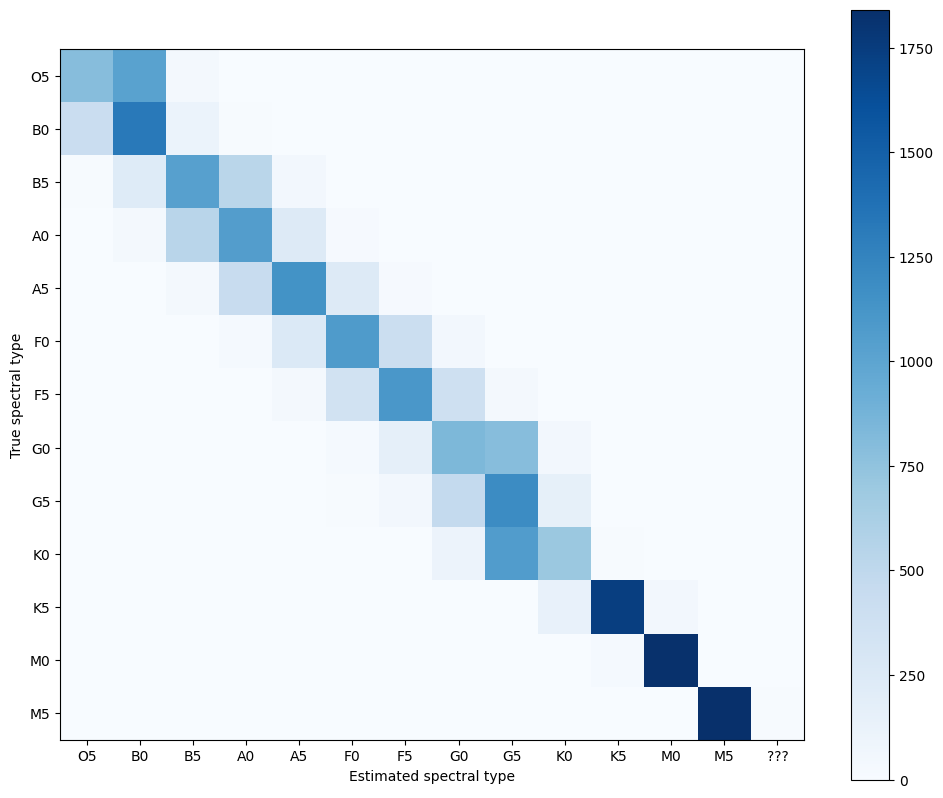

In [21]:
# Plot the confusion matrix

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

plt.figure(figsize= (12,10))
heatmap = plt.imshow(confusion_matrix[:13,:], cmap='Blues')
plt.xticks(np.arange(14), star_class_labels + ['???'])
plt.yticks(np.arange(13), star_class_labels)
plt.colorbar(heatmap)
plt.xlabel("Estimated spectral type")
plt.ylabel("True spectral type")
plt.show()

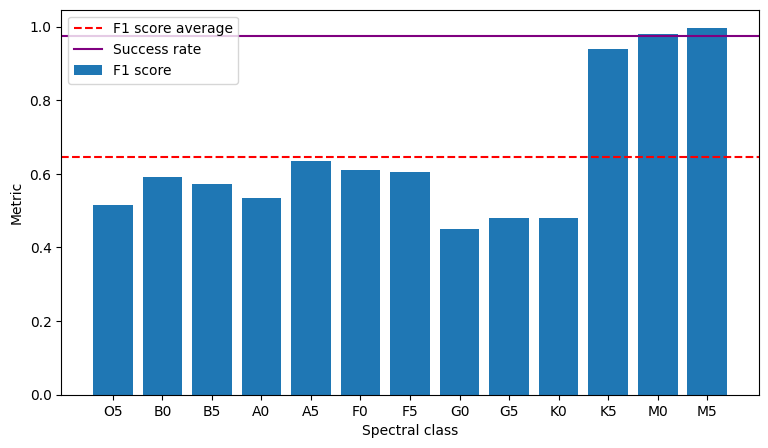

In [22]:
# Plot the metrics

plt.figure(figsize = (9,5))
plt.bar(np.arange(13), height = f1[:13], tick_label = star_class_labels ,label = "F1 score")
plt.axhline(f1_mean, color='red', linestyle='--', label = 'F1 score average')
plt.axhline(success_rate, color='purple', label = 'Success rate')
plt.xlabel("Spectral class")
plt.ylabel("Metric")
plt.legend()

Total training time: 998.7971739768982 seconds
Training loss: 0.12533016502857208 , Validation loss: 0.136705219745636


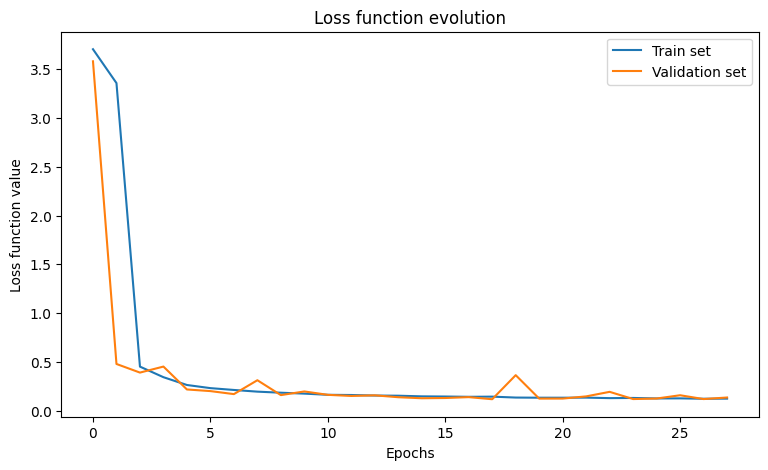

In [24]:
# PLot the loss function evolution

loss_evolution = learning.history["loss"]
val_loss_evolution = learning.history["val_loss"]

plt.figure(figsize = (9,5))
plt.plot(loss_evolution,label = "Train set")
plt.plot(val_loss_evolution,label = "Validation set")
plt.xlabel("Epochs")
plt.ylabel("Loss function value")
plt.legend()
plt.title("Loss function evolution")
print("Total training time:", training_time, "seconds")
print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])


In [26]:
for i in range(25):
    pred=str(SED_pred[i])
    test=str(SED_true[i])
    if pred == test:
        print('\033[4m'+test+' vs '+pred+'\033[0m')
    else:
        print(test+' vs '+pred)


2 vs 2
3 vs 2
9 vs 8
7 vs 7
0 vs 1
3 vs 4
5 vs 5
12 vs 12
10 vs 10
1 vs 1
1 vs 1
7 vs 7
5 vs 5
5 vs 6
9 vs 7
1 vs 1
11 vs 11
2 vs 3
11 vs 11
5 vs 5
1 vs 1
4 vs 4
5 vs 5
0 vs 0
1 vs 1
